In [ ]:
# Copyright 2023 Regeneron Pharmaceuticals Inc.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

## Notebook showing tracking of latent space smoothness over single latent traversal

In [1]:
import pandas as pd
from umap import UMAP
import matplotlib.pyplot as plt
import seaborn as sns

import sys

from tcrvalid.load_models import *
from tcrvalid.plot_utils import set_simple_rc_params
from tcrvalid.physio_embedding import SeqArrayDictConverter,manhattan
from tcrvalid.interpolation import *
from tcrvalid.defaults import *

set_simple_rc_params()

/data/home/peter.hawkins/.conda/envs/tcrvalid_pip_e/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(21, 7)
(22, 8)


### Load models and data
 - load reference CDR2 library
 - load TRB models for two models

In [2]:
from_keras=True

ref_cdr2s,ref_cdr2_seqs = get_ref_cdr2s(trbv_ref_path)
loaded_models = load_named_models(['0_0','1_2'],chain='TRB',as_keras=from_keras)
loaded_decoders = load_named_models(['0_0','1_2'],chain='TRB',as_keras=from_keras,encoders=False)

2023-05-11 11:10:31.729712: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-05-11 11:10:31.729758: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (gen-queue-dy-m516xlarge-1): /proc/driver/nvidia/version does not exist
2023-05-11 11:10:31.730305: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### choose two TCRs with same CDR3, and number if steps to complete in latent space

 - walk linearly in the model's latent space between these two TCRs
 - with number of steps provided
 - expect CDR3 to stay approximately the same, and CDR2 to remain close to true data manifold.

In [3]:
tcr1 = 'YYEKEE-ASSRAGNTEAF'
tcr2 = 'SYGVNS-ASSRAGNTEAF'
interp_steps = 100

### Set up tools to track smoothness

 - we provide some tracking tools:
   - cdr2 tracker and cdr3 tracker used here

In [4]:
cdr2_d_tracker = CDR2DistanceTracker(ref_cdr2s,6,manhattan)
cdr3_d_tracker = CDR3DistanceTracker(None,manhattan)

tracker_tuples = [
  (cdr2_d_tracker,mean_statistic,'CDR2'),
  (cdr3_d_tracker,mean_statistic,'CDR3'),
  (cdr3_d_tracker,mean_startendnorm_statistic,'CDR3_norm')
]

### Construct Interpolator helper - performs the traversal in latent space
 - The interpolator also accepts trackers (created above) to observe the desired quantities at each step on the traversal
 - For each added value to track, a statistic can be provided to capture a single value for the traversal, here use the mean, or normalized mean
 - can also name each of the tracked quantities as desired

In [5]:
mapping = SeqArrayDictConverter()
interp = Interpolator(mapping)
interp.add_tracker(cdr2_d_tracker,mean_statistic,'CDR2')
interp.add_tracker(cdr3_d_tracker,mean_statistic,'CDR3')
interp.add_tracker(cdr3_d_tracker,mean_startendnorm_statistic,'CDR3_norm')

## Perform traversal and plot result

For each model perfom the traversal using the "interp" object created above, going between the twi TCRs defined earlier in the notebook

Plot CDR2 and CD3 (normed) distance along the traversal.

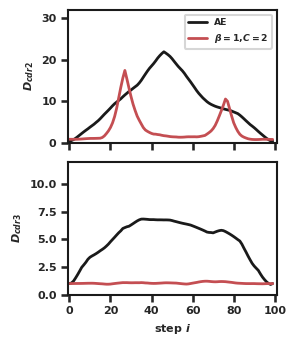

In [6]:
f,axes = plt.subplots(2,1,figsize=(3,3.5))

cols = {
  '0_0': 'k',
  '1_2': 'r',
}
names = {
  '0_0': 'AE',
  '1_2': r'$\beta=1$'+','+r'$C=2$'
}

for k in ['0_0','1_2']: 
    rd = interp(
        tcr1,
        tcr2,
        loaded_models[k],
        loaded_decoders[k],
        interp_steps,
      )
    axes[0].plot(
        interp.tracked_values['CDR2'],
        color=cols[k],
        label=names[k] #+' ; '+r'$C_{CDR2}=$' + '{:.1f}'.format(rd['CDR2'])
    )
    axes[1].plot(
        interp.tracked_values['CDR3']/(0.5*(interp.tracked_values['CDR3'][0]+ interp.tracked_values['CDR3'][-1])),
        color=cols[k],
        label=names[k] #+' ; '+r'$D_{CDR3,norm}=$' + '{:.1f}'.format(rd['CDR3_norm'])
    )
    #print(k, interp.tracked_values['CDR2'])

for ax in axes:
    ax.set_xlim([-0.5,interp_steps+1])
    
axes[0].legend()

axes[0].set_ylim([0,32])
axes[1].set_ylim([0,12])

axes[0].set_ylabel(r'$D_{cdr2}$')
axes[1].set_ylabel(r'$D_{cdr3}$')

axes[1].set_xlabel('step '+r'$i$')
axes[0].set_xticklabels([])

plt.tight_layout()

### Collecting many such traversals to quantify the smoothness of the models

In order to 'score' the smoothness of the latent space by these quantities, one can repeat the analysis for many such pairs of TCRs. For each pair, one can collect the aggregated metric (mean, normalized mean) over the trajectory. We show how to do this in:
 - scripts/meta_interpolation.py